# Quasi-criticality in the Cortex

## Imports

In [ ]:
'''Setup notebook environment -q flag suppresses output, if you want to see it, remove the -q flag'''
# %pip install -r requirements.txt -q
from utils.plotting_utils import *
from utils.data_utils import *
from utils.utils import *
from branching import BranchingNeurons
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import powerlaw
import multiprocessing as mp
from functools import partial
from tqdm.notebook import tqdm
from sandpile import BTW
from collections import Counter
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Branching model

In [ ]:

TESTING = True 
file = 'data/branching_data_densities.csv'
if not os.path.exists(file) or TESTING:
    if TESTING:
        os.remove(file)
    for branching_ratio in tqdm(np.logspace(np.log10(0.5), np.log10(5), 20)):
        for i in [0,1,3,5]:
            kwargs = {
                'N': 100,
                'max_neighbors': 28,
                'cooldown': i,
                'branching_ratio': branching_ratio,
                'visual': False,
            }
            data = simulate(BranchingNeurons, n_runs=10, duration=10000, **kwargs)
            write_data(data, file)


In [ ]:
TESTING = False
file = 'data/branching_data_final.csv'
if not os.path.exists(file) or TESTING:
    if TESTING:
        pass
    for branching_ratio in tqdm(np.logspace(np.log10(0.5), np.log10(5), 20)):
        kwargs = {
            'N': 2500,
            'max_neighbors': 28,
            'branching_ratio': branching_ratio,
            'visual': False,
        }
        data = simulate(BranchingNeurons, n_runs=10, duration=10000, **kwargs)
        write_data(data, file)


In [ ]:
data = pd.read_csv('data/branching_data_final.csv', header=0, index_col=0)
data['mean_density'] = data['density'].apply(float)
data['evalanche_duration'] = data['evalanche_duration'].apply(str_to_list)
data['evalanche_size'] = data['evalanche_size'].apply(str_to_list)

data['density_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[0], axis=1)
data['density_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[0], axis=1)
data['values_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[1], axis=1)
data['values_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[1], axis=1)

data.head()


In [ ]:
grouped_branching = data.groupby('branching_ratio').mean(numeric_only=True)
critical_point = closest_index_to_value(grouped_branching.index, 1)
critical_data = grouped_branching.loc[grouped_branching.index == grouped_branching.index[critical_point]]


In [ ]:
kwargs = {
    'N': 500,
    'max_neighbors': 28,
    'branching_ratio': None,
    'visual': False,
}
plot_activity_per_time_step(10000, **kwargs)

In [ ]:
plt.scatter(grouped_branching.index, grouped_branching['emperical_branching_ratio'], label='Branching ratio')
plt.plot(np.linspace(np.min(grouped_branching.index), np.max(grouped_branching.index), 100), np.linspace(0, np.max(grouped_branching.index), 100), label='1:1 line', color='black', linestyle='--' , alpha=0.5)
plt.xlabel('Branching ratio')
plt.ylabel('Emperical branching ratio')
plt.legend()
plt.show()

In [ ]:
data_cooldowns = pd.read_csv('data/branching_data_densities.csv', header=0, index_col=0)
grouped_cooldowns = data_cooldowns.groupby(['cooldown', 'branching_ratio']).agg({'density': ['mean', 'std']})

for i in [0,1,3,5]:
    plt.plot(grouped_cooldowns.loc[i].index, grouped_cooldowns.loc[i]['density']['mean'], label=f'Cooldown {i}')
    plt.fill_between(grouped_cooldowns.loc[i].index, grouped_cooldowns.loc[i]['density']['mean'] - grouped_cooldowns.loc[i]['density']['std'], grouped_cooldowns.loc[i]['density']['mean'] + grouped_cooldowns.loc[i]['density']['std'], alpha=0.2)
plt.xlabel('Branching ratio')
plt.ylabel('Density')
plt.xlim(0.5, 5)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [ ]:
plt.plot(grouped_branching.index, grouped_branching['mean_density'])
plt.scatter(grouped_branching.index, grouped_branching['mean_density'])

plt.scatter(grouped_branching.index.values[critical_point], grouped_branching['mean_density'].values[critical_point], c='r')
plt.text(grouped_branching.index.values[critical_point] + 0.2, grouped_branching['mean_density'].values[critical_point], 'Critical Point')
plt.xlabel('Branching Ratio')
plt.xlim(0.5, 3)
plt.ylabel('Mean Density')
plt.title('Mean Density vs Branching Ratio')
plt.show()


In [ ]:

def loglog_plotting(type: str, data: pd.DataFrame, grouped_branching: pd.DataFrame):
    fig, ax =plt.subplots(3,2, figsize=(15,15))
    ax = ax.ravel()
    for i in range(6):
        offset = 4

        all_critical_points =  data.loc[data['branching_ratio'] == grouped_branching.index[offset+i]]
        all_data = np.concatenate(all_critical_points[type].values)
        all_data = all_data[all_data > 0]

        fit = powerlaw.Fit(all_data, verbose=False)
        lognormal = powerlaw.Lognormal(verbose=False)
        lognormal.fit(all_data)
        mu, sigma = lognormal.mu, lognormal.sigma

        log_llkhood, p_value = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

        x_values = np.linspace(min(all_data), max(all_data), len(all_data))
        fitted_line = (x_values ** -fit.alpha)
        log_fitted = lognormal.pdf(x_values)
        

        powerlaw.plot_pdf(all_data, ax=ax[i], color='red', label='Empirical data' , linestyle='None', marker='o', markersize=3, alpha=0.5)
        ax[i].plot(x_values, fitted_line, color='black', linestyle='--', label='Power law fit')
        ax[i].plot(x_values, log_fitted, color='blue', linestyle='--', label='Log Normal fit')

        ax[i].set_title(f'Branching ratio: {grouped_branching.index[offset+i]:.2f}')
        ax[i].text(0.1, 0.1, 
           f'$\\alpha$: {fit.alpha:.2f}\n$\\mu$: {mu:.2f}\n$\\sigma$: {sigma:.2f}\n$p$: {p_value:.3f}\nLog Likelihood: {log_llkhood:.3f}', 
           transform=ax[i].transAxes)

        ax[i].set_xlabel(type.split('_')[0].capitalize() + ' ' + type.split('_')[1])
        ax[i].set_ylabel('Frequency')
        
        if i == 1:
            ax[i].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
        

In [ ]:


def loglog_plotting_size_duration(type: List[str], data: pd.DataFrame, grouped_branching: pd.DataFrame):
    fig, ax =plt.subplots(3,2, figsize=(15,15))
    ax = ax.ravel()
    for i in range(6):
        offset = 4

        all_data=  data.loc[data['branching_ratio'] == grouped_branching.index[offset+i]]

        all_size = np.concatenate(all_data[type[0]].values)
        all_size = all_size[all_size > 0]

        all_duration = np.concatenate(all_data[type[1]].values)
        all_duration = all_duration[all_duration > 0]



        ax[i].set_title(f'Branching ratio: {grouped_branching.index[offset+i]:.2f}')
        ax[i].loglog(all_size, all_duration, color='red', linestyle='None', marker='o', markersize=3, alpha=0.5)
        ax[i].set_xlabel(type[0].split('_')[0].capitalize() + ' ' + type[0].split('_')[1])
        ax[i].set_xlabel(type[1].split('_')[0].capitalize() + ' ' + type[1].split('_')[1])

        if i == 1:
            ax[i].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
        

In [ ]:
loglog_plotting("evalanche_duration", data, grouped_branching)
loglog_plotting("evalanche_size", data, grouped_branching)

In [ ]:
loglog_plotting_size_duration(['evalanche_size', 'evalanche_duration'], data, grouped_branching)

### Optimize information processing

#### Get the data

In [ ]:
branching_ratios = np.linspace(0.2, 3, 15)
input_nums = list(range(1, 50, 2))
mutual_infos = []
dynamic_ranges = []
susceptibilities = []
for branching_ratio in branching_ratios:
    kwargs = {
        'N': 100,
        'max_neighbors': 8,
        'branching_ratio': branching_ratio,
        'visual': False,
    }
    # TODO: Initialize the network
    output_nums = []
    sus_list = []
    for input_num in input_nums:
        # TODO: Reset the state of the network
        # TODO: Activate input_num neurons in the first layer
        # TODO: Run the simulation for 10 time steps, and collect the spike_history (should be a list with length 10, whose elements are the number of spikes in each layer/time step)
        output_nums.append(spike_history[-1])
        sus_list.append(susceptibility(spike_history, 100))
    mutual_infos.append(mutual_info(input_nums, output_nums))
    dynamic_ranges.append(dynamic_range(output_nums))
    susceptibilities.append(np.mean(sus_list))
        

#### Plot

In [ ]:
# Show mutual information vs. branching ratio
mutual_info_plot(mutual_infos, branching_ratios)

In [ ]:
# Show the dynamic range of a certain branching ratio
i = 4   # the index of the branching ratio you want to plot
dynamic_range_plot(dynamic_ranges[i][0], dynamic_ranges[i][1], branching_ratios[i])

In [ ]:
# Show susceptibility vs. branching ratio
susceptibility_plot(susceptibilities, branching_ratios)

## BTW-like model

#### Write data

##### df: index, spikes_total, spikes_input, spikes_neighbours

For different patterns:

In [ ]:
settings1 = [
    {"name": "round_spiral", "params": {"height": 4, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "pulse_wave", "params": {"height": 5, "refractory_period": 3, "probability_of_spontaneous_activity": 0.03, "max_distance": 3, "random_connection": False}},
    {"name": "synchronous", "params": {"height": 3, "refractory_period": 5, "probability_of_spontaneous_activity": 0.015, "max_distance": 2.5, "random_connection": True}},
    {"name": "oscillatory", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "repeating", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": True}},
    {"name": "random", "params": {"height": 5, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}}]

In [ ]:
# Data collection to csv in df: spikes_input, spikes_neighbours, spikes_total per time step
for setting in settings1:
    btw = BTW(grid_size=[50, 50], **setting['params'])
    btw.run(10000)
    path = f"data/spikes_btw_{setting['name']}.csv"
    btw.write_data(path)

In [ ]:
# see what's the pattern like for different patterns
paths = [f"data/spikes_btw_{setting['name']}.csv" for setting in settings1]
for path in paths:
    df = load_data_csv(path)
    sigma = branching_prameter(df)
    print(path, sigma)


For more parameters settings:

##### df: avalanche_size, avalanche_duration

This is used to store raster data, which is not used later.

In [ ]:
for setting in settings2:
    btw = BTW(grid_size=[50, 50], **setting['params'])
    btw.init_grid("random", 4)
    btw.run(10000)
    path = f"data/spikes_btw_avalanche/spikes_btw_{setting['name']}.csv"
    btw.collect_raster_data(10000, path) # This function: collect raster data was once used to collect raster data in csv files.

This is used to store raster data for different patterns, which is also used plot spike activity figures.

In [ ]:
for setting in settings1:
    btw = BTW(grid_size=[20, 20], ** setting['params'])
    btw.init_grid("random", 4)
    btw.run(1500)
    path = f"data/spikes_btw_avalanche_grid/spikes_btw_{setting['name']}.csv"
    df = btw.collect_raster_data(5000)
    df.to_csv(path)

This is used to store avalanche data, which is also used to plot power law distributions later.

In [ ]:
settings3 = [{"name": f"ref{ref}thresh{thresh}p{p}", 
            "params": {"height": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(2, 8) for thresh in range(2, 8) for p in [0.015, 0.02, 0.025]]
paths_avalanche = []
settings4 = []
for setting in settings3:
    btw = BTW(grid_size=[20, 20], **setting['params'])
    btw.init_grid("random", 4)
    btw.run(10000)
    df_raster = btw.collect_raster_data(3000)
    df = raster_to_basic(df_raster)
    sigma = branching_prameter(df)
    print(sigma)
    if(abs(sigma-1) < 0.05):
        settings4.append(setting)

In [ ]:
if(abs(branching_prameter(df)-1) < 0.05):
        df_transmission = raster_to_transmission(df_raster)
        avalanche = transmission_to_avalanche(df_transmission)
        avalanche_df = avalanche_to_statistics(avalanche)
        avalanche_df.to_csv(path, index=True)    
        paths_avalanche.append(path)
        print("Data written to:", path)

### Average Spike Density vs. Branching Ratio m

In [ ]:
# Plot avg_spike_density vs. m
settings2 = [{"name": f"ref{ref}thresh{thresh}p{p}r{False}", 
            "params": {"height": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(1, 8) for thresh in range(1, 7) for p in [0.015,0.02,0.025]]
# The write data is neglected in this ipynb for clarification. It's similar to what we did to the settings1.
paths = [f"data/spikes_btw_ref_thresh/spikes_btw_{setting['name']}.csv" for setting in settings2]
size = 50
spike_density_plot(paths, size)

In [ ]:
# Plot avg_spike_density vs. m considering refractory period 
settings2 = [{"name": f"ref{ref}thresh{thresh}p{p}r{False}", 
            "params": {"height": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(1, 8) for thresh in range(1, 7) for p in [0.015,0.02,0.025]]
# The write data is neglected in this ipynb for clarification. It's similar to what we did to the settings1.
paths = [f"data/spikes_btw_ref_thresh/spikes_btw_{setting['name']}.csv" for setting in settings2]
refs = [setting['params']['refractory_period'] for setting in settings2]
size = 50
ref_spike_density_plot(paths, size, refs)

### Avalanche size/duration distribution (distinguishing origins)

In [ ]:
avalanches = []
# This for loop takes a long time to run.
# You can just run the third cell to load the data from the csv files.
for i in range(20):
    # This is a parameter setting we selcted which sigma is near 1.
    btw = BTW(grid_size=[50, 50], refractory_period=3,height=2,probability_of_spontaneous_activity=0.02,max_distance=3,random_connection=False)
    raster_df = btw.collect_raster_data(1000)
    df = raster_to_basic(raster_df)
    df_transmission = raster_to_transmission(raster_df)
    avalanche = transmission_to_avalanche(df_transmission)
    avalanche_df = avalanche_to_statistics(avalanche)
    avalanches.append(avalanche)
all_avalanches = [item for sublist in avalanches for item in sublist]




In [ ]:
avalanche_df = avalanche_to_statistics(all_avalanches)
avalanche_df.to_csv("data/avalanche_powerlaw_df.csv", index=True)
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}

Calculating best minimal value for power law fit
/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/Users/eva/anaconda3/lib/python3.11/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


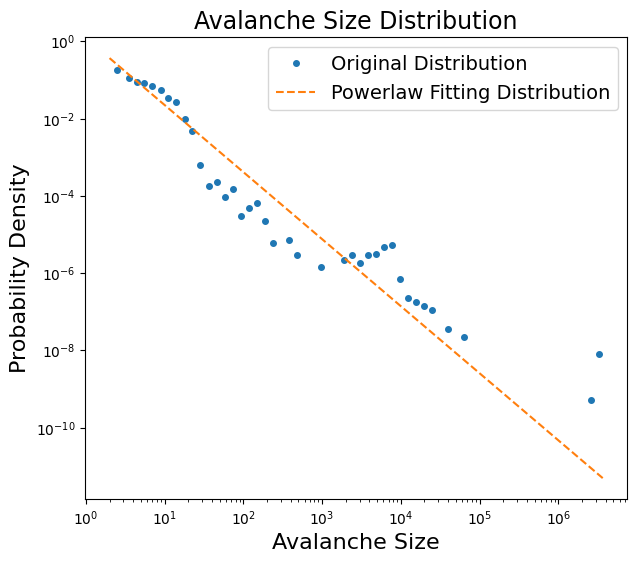

Tau (τ) - Power-law exponent: 1.735105657225038


In [15]:
# Run this cell to get plot directly
df = load_data_csv("data/avalanche_powerlaw_df.csv")
avalanche_sizes = df['size'].tolist()
fit = powerlaw.Fit(avalanche_sizes)
fig, ax = plt.subplots(figsize=(7, 6))
plt.style.use('tableau-colorblind10') 

fit.plot_pdf(ax=ax,linestyle='None', marker='o', markersize=4, label='Original Distribution')
fit.power_law.plot_pdf(linestyle='--', ax=ax, label='Powerlaw Fitting Distribution')
plt.legend(fontsize=14)
plt.xlabel("Avalanche Size", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.title("Avalanche Size Distribution", fontsize=17)
plt.show()
print('Tau (τ) - Power-law exponent:', fit.power_law.alpha)


### Grid activity

In [ ]:
paths = [f"data/spikes_btw_avalanche_grid/spikes_btw_synchronous.csv"]# Change the path to get diffenrent activity plots
spike_activity_plot(paths, 20)

### Spike Density vs timestep

In [ ]:
settings3 = [{"name": f"ref{ref}thresh{t}p{p}r{r}", 
            "params": {"height": t, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": p, 
                        "max_distance": 3, 
                        "random_connection": r}}
            for ref in range(1, 8) for t in range(1, 8) for p in [0.015, 0.02, 0.025] for r in [False, True]]
paths = [f"data/spikes_btw_ref_thresh/spikes_btw_{setting['name']}.csv" for setting in settings3]
for path in paths:
    df = pd.read_csv(path)
    r = branching_prameter(df)
    if(abs(r - 1) < 0.05):
        print("paths: ", path)
        print(r)

In [ ]:
paths = ["data/spikes_btw_ref_thresh/spikes_btw_ref2thresh3p0.02rFalse.csv",
         "data/spikes_btw_ref_thresh/spikes_btw_ref4thresh4p0.015rFalse.csv",
         "data/spikes_btw_ref_thresh/spikes_btw_ref6thresh6p0.015rTrue.csv"]
size = 50
grid_activity_timestep(paths, 50)

### Scale-free Property

In [16]:
avalanches = []
# This loop takes a long time to run. 
# To get the result figure we showed in the presentation, you can just run the third block in this section.
for i in range(10): 
    btw = BTW(grid_size=[50, 50], refractory_period=3,height=2,probability_of_spontaneous_activity=0.02,max_distance=3,random_connection=False)
    raster_df = btw.collect_raster_data(1000)
    df = raster_to_basic(raster_df)
    df_transmission = raster_to_transmission(raster_df)
    avalanche = transmission_to_avalanche(df_transmission)
    avalanches.append(avalanche)
all_avalanches = [item for sublist in avalanches for item in sublist]
print(all_avalanches)
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}



[[1, 1], [1, 5], [1, 15], [1, 21], [1, 7], [1, 5], [1, 4], [1, 4], [1, 3], [1, 1], [1, 6], [1, 3], [1, 1], [1, 8], [1, 7], [1, 8], [1, 5], [1, 2], [1, 1], [1, 8], [1, 8], [1, 8], [1, 4], [1, 3], [1, 2], [1, 8], [1, 8], [1, 6], [1, 4], [1, 2], [1, 9], [1, 8], [1, 5], [1, 6], [1, 8], [1, 4], [1, 1], [1, 3], [1, 1], [1, 2], [1, 1], [1, 4], [1, 9], [1, 2], [1, 4], [1, 2], [1, 6], [1, 9], [1, 4], [1, 5], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 2], [1, 3], [1, 4], [1, 4], [1, 3], [1, 5], [1, 5], [1, 3], [1, 6], [1, 4], [1, 1], [1, 4], [1, 7], [1, 10], [1, 6], [1, 10], [13, 15, 13], [12, 13, 17], [2, 27, 115, 67], [27, 51, 112, 186, 96], [7, 45, 277, 524, 428, 354, 20], [1, 20], [1, 18], [1, 4], [1, 2], [1, 1], [1, 1], [1, 6], [1, 4], [1, 2], [1, 6], [1, 6], [1, 4], [1, 1], [1, 3], [1, 4], [1, 4], [1, 3], [1, 2], [1, 2], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1

In [17]:
# Convert the all_avalnches to csv
df = pd.DataFrame({'avalanches': all_avalanches})
df.to_csv('data/avalanche_statistics_scalefree.csv', index=True)

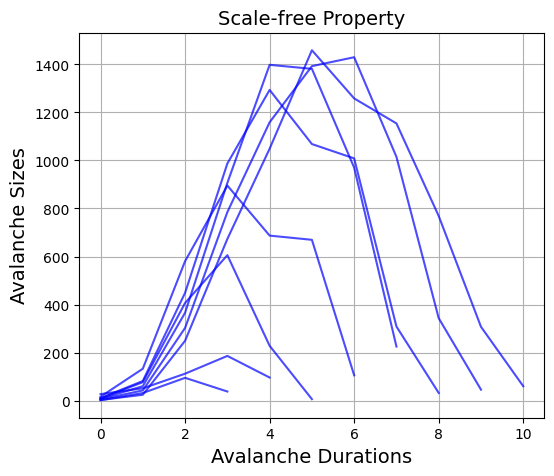

In [19]:
# avalanche size vs. avalanche duration for scale-fee property
df = load_data_csv("data/avalanche_statistics_scalefree.csv")
all_avalanches = df['avalanches'].apply(eval).tolist()
avalanches_by_length = defaultdict(list)
for av in all_avalanches:
    avalanches_by_length[len(av)].append(av)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}
plt.figure(figsize=(6, 5)) 
plt.title("Scale-free Property", fontsize=14)
plt.xlabel("Avalanche Durations", fontsize=14)
plt.ylabel("Avalanche Sizes", fontsize=14)
plt.grid(True)
for length, mean_activity in mean_activities.items():
    if length < 15 and length > 3:
        plt.plot(range(length), mean_activity, label=f'Duration {length}', color='blue', alpha=0.7)

plt.show()

In [ ]:
# Linear regression(Not used in the presentation)
mean_activities = {length: np.mean(np.array(avs), axis=0) for length, avs in avalanches_by_length.items()}
durations = []
sizes = []
for duration, activities in mean_activities.items():
    if duration < 17 and duration > 5:
        durations.append(duration)
        sizes.append(np.mean(activities))
log_durations = np.log(durations).reshape(-1, 1)
log_sizes = np.log(sizes)
model = LinearRegression()
model.fit(log_durations, log_sizes)
predicted = model.predict(log_durations)
gamma = model.coef_[0]
r2 = r2_score(log_sizes, predicted)
plt.figure(figsize=(8, 6))
plt.scatter(log_durations, log_sizes, color='black', label='Data points')
plt.plot(log_durations, predicted, color='red', label=f'Linear fit: γ = {gamma:.2f}, R² = {r2:.2f}')
plt.legend()
plt.xlabel('Log(duration)')
plt.ylabel('Log(size)')
plt.title('Log-Log Plot of Avalanche Duration vs Size')
plt.show()

#### Plot the scalefree with zooming

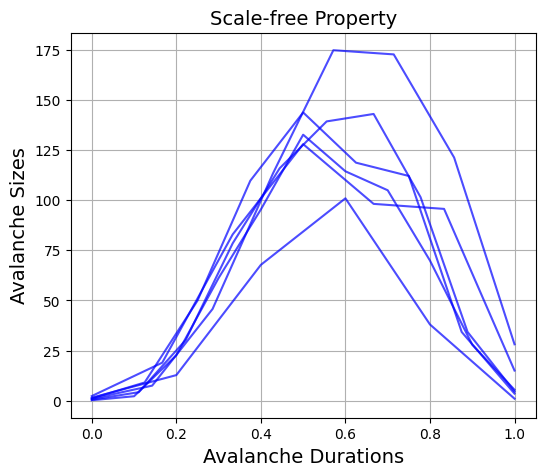

In [25]:
plt.figure(figsize=(6, 5)) 
plt.title("Scale-free Property", fontsize=14)
plt.xlabel("Avalanche Durations", fontsize=14)
plt.ylabel("Avalanche Sizes", fontsize=14)
plt.grid(True)
for length, mean_activity in mean_activities.items():
    if length < 15 and length > 5 :
        scaled_time = [i / (length - 1) for i in range(length)]
        scaled_activity = [activity / ((length) ** (2- 1)) for activity in mean_activity]
        plt.plot(scaled_time, scaled_activity, label=f'Duration {length}', color='blue', alpha=0.7)

plt.show()


### Testing varying parameters to catch the phase transitions

In [ ]:
height_values = range(1, 10)
average_densities = []

for height in height_values:
    file_name = f"data/new_varying_height_{height}.csv"
    data = pd.read_csv(file_name)

    average_density = data['spikes_total'].mean() / (50 * 50)
    average_densities.append(average_density)

In [ ]:
height_values = range(1, 10)
refractory_periods = [2, 3, 4, 5, 6, 7, 8]

plt.figure(figsize=(10, 6))

for refractory_period in refractory_periods:
    average_densities = []

    for height in height_values:
        file_name = f"data/new_varying_height_{height}_ref_{refractory_period}.csv"
        data = pd.read_csv(file_name)

        average_density = data["spikes_total"].mean() / (50 * 50)
        average_densities.append(average_density)

    plt.plot(height_values, average_densities, marker='o', label=f'Refractory {refractory_period}')

plt.xlabel('Height')
plt.ylabel('Average Density of Active Neurons')
plt.title('Density-Height Phase Transitions for Different Refractory Periods')

plt.legend(title="Refractory Periods")
plt.grid(True)
plt.show()

In [ ]:
branching_params_by_ref = {rp: [] for rp in refractory_periods}

for rp in refractory_periods:
    for height in height_values:
        file_name = f"data/new_varying_height_{height}_ref_{rp}.csv"
        data = pd.read_csv(file_name)
        sigma= branching_prameter(data)
        branching_params_by_ref[rp].append(sigma)

plt.figure(figsize=(10, 6))
for rp, branching_params in branching_params_by_ref.items():
    plt.plot(height_values, branching_params, marker='o', label=f'Refractory{rp}')

plt.xlabel('Height')
plt.ylabel('Branching Parameter')
plt.title('Branching Parameter vs. Height for Different Refractory Periods')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(height_values, average_densities, marker='o')
plt.xlabel('Height')
plt.ylabel('Average Density of Active Neurons')
plt.title('Density-Height Phase Transitions')
plt.grid(True)
plt.show()

In [ ]:
branching_params = []

for height in height_values:
    filename = f"data/new_varying_height_{height}.csv"
    data = pd.read_csv(filename)
    sigma = branching_prameter(data)
    branching_params.append(sigma)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(height_values, branching_params, marker='o')
plt.xlabel('Height')
plt.ylabel('Branching Parameter')
plt.title('Branching Parameter vs. Height')
plt.grid(True)
plt.show()

In [ ]:
height_to_check = [3, 4]
branching_parameters = {}

for height in height_to_check:
    file_name = f"data/varying_height_{height}.csv"
    data = pd.read_csv(file_name)
    sigma = branching_prameter(data)  # Ensure the function name is correctly spelled as 'branching_parameter'
    branching_parameters[height] = sigma

print(branching_parameters)

In [ ]:
refractory_period_values = range(1, 10)
average_densities_1 = []

for refractory_period in refractory_period_values:
    filename = f"data/new_varying_refractory_{refractory_period}.csv"
    data_1 = pd.read_csv(filename)

    average_density_1 = data_1['spikes_total'].mean() / (50 * 50)
    average_densities_1.append(average_density_1)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(refractory_period_values, average_densities_1, marker='o')
plt.title("Refractory Period vs. Average Density of Active Neurons")
plt.xlabel("Refractory Period")
plt.ylabel("Average Density of Active Neurons")
plt.grid(True)
plt.show()

In [ ]:
refractory_period_to_check = [3, 4]
branching_parameters = {}

for refractory_period in refractory_period_to_check:
    file_name = f"data/new_varying_refractory_{refractory_period}.csv"
    data = pd.read_csv(file_name)
    sigma = branching_prameter(data)
    branching_parameters[refractory_period] = sigma

print(branching_parameters)

In [ ]:
branching_params = []

for refractory_period in refractory_period_values:
    filename = f"data/new_varying_refractory_{refractory_period}.csv"
    data = pd.read_csv(filename)
    sigma = branching_prameter(data)
    branching_params.append(sigma)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(refractory_period_values, branching_params, marker='o')
plt.xlabel('Refractory Period')
plt.ylabel('Branching Parameter')
plt.title('Branching Parameter vs. Refractory Period')
plt.grid(True)
plt.ylim([min(branching_params) - 0.6, max(branching_params) + 0.6])
plt.show()

## Logic for presentation:
### Motivation
### Data we use: self-generated?
### Hypothesis
### What we did:
#### CA Model: 
##### How is this Model like？
1. Rules: 
   1. We have a 2d grid. 
   2. Interact rule: The neighbour neurons around spikes are going to be added 1 to their grid number. If in ths time step, neurons who get enough gird number, which means reaches the threshold, becomes a spike_neighbour in the next time step. And if they donot reach the threshold, their grid numbers will be cleared to zero.
   3. Refractory period: After 1 timestep, a spike will get into the refractory period, which means within the next refractoy period timesteps, the spike will get activated whatever happens.
   4. Spontaneous spike rule: We have this spontaneous_input_probability p to make random unactivated and also not in refractory period neurons to activate and become a spike_input.
   5. So, we have a big timestep for loop, we first make all spikes into refractory period and also make spikes in refractory period in time -1 refractory period. This will take effect at the next timestep. Then we check neighbours to create spikes_neighbours and then we add_grains to make spikes_input.
2. Parameters(max_height,refractory_period,spontaneous_input_probability,random_connection，max_distance)
##### What we get: 
1. By playing with the parameters tuning, we find patterns(vedios and raster figure). 
2. While running on different settings of parameters, we find the phase transition around branching ratio =1.
3. While changing only one parameter (let's say a) each time, we find the interesting relationship beween spike_density and a. In principle, what we are doing is changing branching ratio. However, the relationship is different for different a. You see it looks like first-order phase transition, but we think actually it's not. It may be just because of our activation rule is adding 1 to your neighbours at one time, but not 0.3 or 0.5. So the data we get is discrete.
4. We tried to delve into the powerlaw distribution of avalanche size and distribution and the relationship between these 2 /tao, but the results we get is for avalanche size, it clearly follows powerlaw distribution, but for avalanche duration distribution, it seems not. We think it's due to in the CA model we implemented, the avalanches tend to merge into one big avalanche. Even though we have implemented a complicated algorithm to track avalanche origins, we still cannot prevent avalanches merging into one big avalanche. So the avalanche data we get often ends with one very big avalanche size and duration number. 
So we want to implement this branching model with random network to make up for the shortcomings of existing models in studying avalanche size and duration distribution.
#### Branching model
##### Model definition
> We create N neurons, all of which get a number of neighbors, unless this is not possible, in which case they might get less. Most neurons will have the same number of neurons. Each edge has a directional probaility of passing on an activation. The sum of these activations is the branching ratio, which is our control parameter. The density of the neurons is defined as the number of neurons that is active at a time step, and is the order parameter.

##### Information transfer
> Although we technically don't have a feedforward model, we can take each time step as a feedforward step. The information is transferred from the neurons that are active to the neurons that are connected to them. The information is transferred with a probability p, which is the branching ratio. We expect the information transfer to be the "longest", meaning the correlation between time steps is the highest, when the branching ratio is 1. This is because the information is will on average not "spread" dilute into chaos or die out. When the branching ratio is lower than 1, the information is lost, and when it is higher than 1, the activations will cause too many new activations, thereby leave no information about the original activation.
